# Evaluation of 2 Models

In [1]:
model_1 = "pix2pix_1_0"
model_1_type = "pix2pix"
model_2 = "pix2pix_1_0_input_base"
model_2_type = "pix2pix"

data_1 = "../../data/nms1000_test_1_0_2500_2500"
data_1_type = "noise"
data_2 = "../../data/nms1000_test_1_0_2500_2500_input_base"
data_2_type = "noise"

### Env Setup

In [2]:
!conda create -n eval python=3.8 -y
!conda activate eval

Retrieving notices: ...working... done
Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/tippolit/anaconda3/envs/eval

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2025.2.25-h06a4308_0 
  ld_impl_linux-64   pkgs/main/linux-64::ld_impl_linux-64-2.40-h12ee557_0 
  libffi             pkgs/main/linux-64::libffi-3.4.4-h6a678d5_1 
  libgcc-ng          pkgs/main/linux-64::libgcc-ng-11.2.0-h1234567_1 
  libgomp            pkgs/main/linux-64::libgomp-11.2.0-h1234567_1 
  libstdcxx-ng       pkgs/main/linux-64::libstdcxx-ng-11.2.0-h1234567_1 
  ncurses            pkgs/main/linux-64::ncurses-6.4-h6a678d5_0 
  openssl            pkgs/main/linux-64::openssl-3.0.16-h5eee18b_0 
  pip                pkgs/m

Activate now eval env and run:

In [ ]:
!pip install pandas
!pip install ipython
!pip install ipykernel
!pip install opencv-python
!pip install shapely
!pip install pytorch-msssim
!pip install -r requirements.txt

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Using cached ipython-8.12.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached backcall-0.2.

> Set 'eval' as your python env

### Imports

In [2]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [33]:
!python --version

Python 3.8.20


### Helper

In [3]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False, log=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    # print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    # print(f"Transformed shape to: {img_shape}")

    # get better look at reflections
    # mask = (img >= 200) & (img <= 240)
    # img[mask] -= 33
    # img = cv2.add(img, np.full(img.shape, 33, dtype=img.dtype))

    # Better distribution
    normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = normalized_img * (255)
    #img = cv2.equalizeHist(img)

    # invert images
    if invert:
        # print("Invert images...")
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    if log:
        img[img <= 0] = 1e-3
        # img = np.apply_along_axis(np.log, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        # print(f"Using '{plt_style}' plotting style.")

    # plotting
    # print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2] == 3:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            # print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        if log:
            cur_ax.imshow(cur_img, cmap=used_cmap, norm=LogNorm())
        else:
            cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False, log=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    elif color_space.lower() in ["grey", "gray", "g"]:
        images = np.array([cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in image_paths])
        images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert, log=log)
    return images

### Run Tests

In [5]:
!python test.py \
  --dataroot {data_1} \
  --name {model_1} \
  --model {model_1_type} \
  --batch_size 18 \
  --dataset_mode {data_1_type} \
  --input_nc 1 \
  --output_nc 1 \
  --load_size 256 \
  --netG unet_256 \
  --max_dataset_size 1000 \
  --num_test 1000 \
  --results_dir ./eval/{model_1} \
  --phase test \
  --eval

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 18                            	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: False                         
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
   

In [6]:
!python test.py \
  --dataroot {data_2} \
  --name {model_2} \
  --model {model_2_type} \
  --batch_size 18 \
  --dataset_mode {data_2_type} \
  --input_nc 1 \
  --output_nc 1 \
  --load_size 256 \
  --netG unet_256 \
  --max_dataset_size 1000 \
  --num_test 1000 \
  --results_dir ./eval/{model_2} \
  --phase test \
  --eval \
  --different_building_naming

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 18                            	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500_input_base	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: True                          	[default: False]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                  

initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/pix2pix_1_0_input_base/latest_net_G.pth
/home/tippolit/src/paired_image-to-image_translation/models/base_model.py:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

### Extract Test Predictions

In [12]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [14]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied real from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_929_real_B.png' to '../../data/eval/pix2pix_1_0/real/buildings_929.png'
[info] copied pred from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_68_fake_B.png' to '../../data/eval/pix2pix_1_0/pred/buildings_68.png'
[info] copied pred from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_595_fake_B.png' to '../../data/eval/pix2pix_1_0/pred/buildings_595.png'
[info] copied real from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_70_real_B.png' to '../../data/eval/pix2pix_1_0/real/buildings_70.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_261_real_A.png' to '../../data/eval/pix2pix_1_0/osm/buildings_261.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_857_real_A.png' to '../../data/eval/pix2pix_1_0/osm/buildings_857.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest

In [15]:
evaluation_path = f"./eval/{model_2}/{model_2}/test_latest/images"
target_path = f"../../data/eval/{model_2}"

In [16]:
!python eval_extractor.py \
    --name {model_2} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied pred from './eval/pix2pix_1_0_input_base/pix2pix_1_0_input_base/test_latest/images/888_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_0_input_base/pred/888_LAEQ.png'
[info] copied osm from './eval/pix2pix_1_0_input_base/pix2pix_1_0_input_base/test_latest/images/348_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_1_0_input_base/osm/348_LAEQ.png'
[info] copied osm from './eval/pix2pix_1_0_input_base/pix2pix_1_0_input_base/test_latest/images/519_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_1_0_input_base/osm/519_LAEQ.png'
[info] copied real from './eval/pix2pix_1_0_input_base/pix2pix_1_0_input_base/test_latest/images/634_LAEQ_256_real_B.png' to '../../data/eval/pix2pix_1_0_input_base/real/634_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_0_input_base/pix2pix_1_0_input_base/test_latest/images/855_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_0_input_base/pred/855_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_0_input_base/pix2pix_1_0_input_base/test_l

### Calc Eval metrics

In [33]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --osm_dir ../../data/eval/{model_1}/osm \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples: 100%|███████████████████| 1000/1000 [00:26<00:00, 37.20it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1000.000000  1000.000000  ...  1000.000000  1000.000000
mean      4.444653    20.969383  ...    20.969429    17.957598
std       1.704149     6.515928  ...     6.516029    11.217666
min       0.647224     3.963208  ...     3.962795     0.000000
25%       3.345735    17.006152  ...    17.006381     8.108115
50%       4.683018    22.305396  ...    22.305449    17.117111
75%       5.679563    25.402956  ...    25.403112    27.586206
max       9.134192    36.809696  ...    36.810001    43.089428

[8 rows x 6 columns]


In [34]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_2}/real \
    --pred_dir ../../data/eval/{model_2}/pred \
    --osm_dir ../../data/eval/{model_2}/osm \
    --output ./eval_results/evaluation_{model_2}.csv

Evaluating samples: 100%|███████████████████| 1000/1000 [00:27<00:00, 36.02it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1000.000000  1000.000000  ...  1000.000000  1000.000000
mean      0.563076     5.169855  ...     5.169905     1.851383
std       0.410332     3.036526  ...     3.036574     0.624482
min       0.168535     0.895809  ...     0.895780     0.000000
25%       0.259800     2.709509  ...     2.709513     1.709401
50%       0.412140     4.519552  ...     4.519600     1.785713
75%       0.742373     7.102148  ...     7.102218     2.484505
max       4.269044    24.152674  ...    24.153013     3.703701

[8 rows x 6 columns]


### Show Results

In [35]:
mae_model_1_name = f'MAE_{model_1}'
los_mae_model_1_name = f'LoS_MAE_{model_1}'
nlos_mae_model_1_name = f'NLoS_MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'
los_wmape_model_1_name = f'LoS_wMAPE_{model_1}'
nlos_wmape_model_1_name = f'NLoS_wMAPE_{model_1}'

mae_model_2_name = f'MAE_{model_2}'
los_mae_model_2_name = f'LoS_MAE_{model_2}'
nlos_mae_model_2_name = f'NLoS_MAE_{model_2}'
mape_model_2_name = f'MAPE_{model_2}'
los_wmape_model_2_name = f'LoS_wMAPE_{model_2}'
nlos_wmape_model_2_name = f'NLoS_wMAPE_{model_2}'

In [36]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
df_1["sample_id"] = df_1["sample_id"].str.extract(r'_*(\d+)_*')[0].astype(int)
df_1

sample_id  MAE_pix2pix_1_0  MAPE_pix2pix_1_0  LoS_MAE_pix2pix_1_0  \
0          893         2.183454         12.806215             2.183452   
1          109         3.831853         20.898878             3.831911   
2          788         5.951747         29.029835             5.951814   
3          974         7.547307         32.820507             7.547405   
4          570         0.862235          4.683415             0.862075   
..         ...              ...               ...                  ...   
995        247         2.209526         11.277959             2.209362   
996        717         6.082255         27.604225             6.082174   
997        366         4.459480         20.418798             4.459386   
998        503         5.262337         22.431097             5.262208   
999        205         5.508064         25.257770             5.508130   

     NLoS_MAE_pix2pix_1_0  LoS_wMAPE_pix2pix_1_0  NLoS_wMAPE_pix2pix_1_0  
0                2.352943              12.806324                5.660383  
1                0.000000              20.899197                0.000000  
2                1.568626              29.030226                3.508770  
3                1.176472              32.820970                2.479341  
4               11.372547               4.683053               28.431372  
..                    ...                    ...                     ...  
995             12.941177              11.277656               31.132078  
996             11.372547              27.604265               24.999998  
997             10.588238              20.418745               23.893810  
998             13.725489              22.430971               30.701754  
999              1.176472              25.258114                2.608698  

[1000 rows x 7 columns]

In [37]:
df_2 = pd.read_csv(f"./eval_results/evaluation_{model_2}.csv")
# df_2 = df_2.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_2 = df_2.rename(columns={'MAE': mae_model_2_name, 
                            'LoS_MAE': los_mae_model_2_name,
                            'NLoS_MAE': nlos_mae_model_2_name,
                            'MAPE':mape_model_2_name,
                            'LoS_wMAPE': los_wmape_model_2_name,
                            'NLoS_wMAPE': nlos_wmape_model_2_name
                            }
                   )
df_2["sample_id"] = df_2["sample_id"].str.extract(r'^(\d+)_')[0].astype(int)
df_2

sample_id  MAE_pix2pix_1_0_input_base  MAPE_pix2pix_1_0_input_base  \
0          707                    0.492410                     5.283690   
1          283                    0.836158                     7.913218   
2          584                    0.726480                     7.436058   
3          967                    1.505480                     9.345755   
4          132                    1.143063                    10.360191   
..         ...                         ...                          ...   
995         92                    0.323241                     3.039711   
996        435                    0.588570                     7.262637   
997        197                    0.837217                     7.156856   
998        689                    0.367132                     3.473402   
999        856                    0.738142                     6.644658   

     LoS_MAE_pix2pix_1_0_input_base  NLoS_MAE_pix2pix_1_0_input_base  \
0                          0.492400                         1.176468   
1                          0.836164                         0.392155   
2                          0.726479                         0.784313   
3                          1.505485                         1.176472   
4                          1.143068                         0.784313   
..                              ...                              ...   
995                        0.323234                         0.784313   
996                        0.588567                         0.784313   
997                        0.837212                         1.176468   
998                        0.367120                         1.176472   
999                        0.738142                         0.784313   

     LoS_wMAPE_pix2pix_1_0_input_base  NLoS_wMAPE_pix2pix_1_0_input_base  
0                            5.283728                           2.830182  
1                            7.913325                           0.854696  
2                            7.436141                           1.960783  
3                            9.345859                           2.521011  
4                           10.360321                           1.851851  
..                                ...                                ...  
995                          3.039729                           1.851851  
996                          7.262718                           1.960783  
997                          7.156923                           2.777772  
998                          3.473416                           2.564105  
999                          6.644730                           1.886791  

[1000 rows x 7 columns]

In [38]:
merged_df = pd.merge(df_1, df_2, on='sample_id', how='outer')
print(f"Value Counts:\n{merged_df.value_counts()}")
print(f"\n\nNulls:\n{merged_df.isna().sum()}\n\n")
merged_df

Value Counts:
sample_id  MAE_pix2pix_1_0  MAPE_pix2pix_1_0  LoS_MAE_pix2pix_1_0  NLoS_MAE_pix2pix_1_0  LoS_wMAPE_pix2pix_1_0  NLoS_wMAPE_pix2pix_1_0  MAE_pix2pix_1_0_input_base  MAPE_pix2pix_1_0_input_base  LoS_MAE_pix2pix_1_0_input_base  NLoS_MAE_pix2pix_1_0_input_base  LoS_wMAPE_pix2pix_1_0_input_base  NLoS_wMAPE_pix2pix_1_0_input_base
0          0.798364         4.485190          0.798226             9.803919              4.484884               24.509800               0.234453                    1.809364                     0.234444                        0.784313                         1.809362                          1.960783                             1
671        5.619369         23.237820         5.619222             15.294117             23.237656              33.913044               0.233501                    1.530530                     0.233493                        0.784313                         1.530526                          1.739129                             

sample_id  MAE_pix2pix_1_0  MAPE_pix2pix_1_0  LoS_MAE_pix2pix_1_0  \
0          893         2.183454         12.806215             2.183452   
1          109         3.831853         20.898878             3.831911   
2          788         5.951747         29.029835             5.951814   
3          974         7.547307         32.820507             7.547405   
4          570         0.862235          4.683415             0.862075   
..         ...              ...               ...                  ...   
995        247         2.209526         11.277959             2.209362   
996        717         6.082255         27.604225             6.082174   
997        366         4.459480         20.418798             4.459386   
998        503         5.262337         22.431097             5.262208   
999        205         5.508064         25.257770             5.508130   

     NLoS_MAE_pix2pix_1_0  LoS_wMAPE_pix2pix_1_0  NLoS_wMAPE_pix2pix_1_0  \
0                2.352943              12.806324                5.660383   
1                0.000000              20.899197                0.000000   
2                1.568626              29.030226                3.508770   
3                1.176472              32.820970                2.479341   
4               11.372547               4.683053               28.431372   
..                    ...                    ...                     ...   
995             12.941177              11.277656               31.132078   
996             11.372547              27.604265               24.999998   
997             10.588238              20.418745               23.893810   
998             13.725489              22.430971               30.701754   
999              1.176472              25.258114                2.608698   

     MAE_pix2pix_1_0_input_base  MAPE_pix2pix_1_0_input_base  \
0                      0.284579                     3.424736   
1                      0.780777                     7.137647   
2                      1.503990                    12.883487   
3                      0.576124                     5.706975   
4                      0.210350                     1.694580   
..                          ...                          ...   
995                    0.276429                     2.580782   
996                    0.786115                     7.111252   
997                    0.444408                     3.712951   
998                    0.368335                     2.778579   
999                    0.434642                     5.345694   

     LoS_MAE_pix2pix_1_0_input_base  NLoS_MAE_pix2pix_1_0_input_base  \
0                          0.284566                         1.176468   
1                          0.780771                         1.176472   
2                          1.503995                         1.176472   
3                          0.576121                         0.784313   
4                          0.210341                         0.784313   
..                              ...                              ...   
995                        0.276422                         0.784313   
996                        0.786115                         0.784313   
997                        0.444403                         0.784313   
998                        0.368323                         1.176472   
999                        0.434643                         0.392155   

     LoS_wMAPE_pix2pix_1_0_input_base  NLoS_wMAPE_pix2pix_1_0_input_base  
0                            3.424746                           2.830182  
1                            7.137715                           2.702706  
2                           12.883643                           2.631581  
3                            5.707037                           1.652891  
4                            1.694576                           1.960783  
..                                ...                                ...  
995                          2.580793       

Using 'seaborn-v0_8' plotting style.

MAE
    - pix2pix_1_0: 4.44
    - pix2pix_1_0_input_base: 0.56

MAPE
    - pix2pix_1_0: 20.97
    - pix2pix_1_0_input_base: 5.17

LoS MAE
    - pix2pix_1_0: 4.44
    - pix2pix_1_0_input_base: 0.56

NLoS MAE
    - pix2pix_1_0: 7.91
    - pix2pix_1_0_input_base: 0.81

LoS wMAPE
    - pix2pix_1_0: 20.97
    - pix2pix_1_0_input_base: 5.17

NLoS wMAPE
    - pix2pix_1_0: 17.96
    - pix2pix_1_0_input_base: 1.85


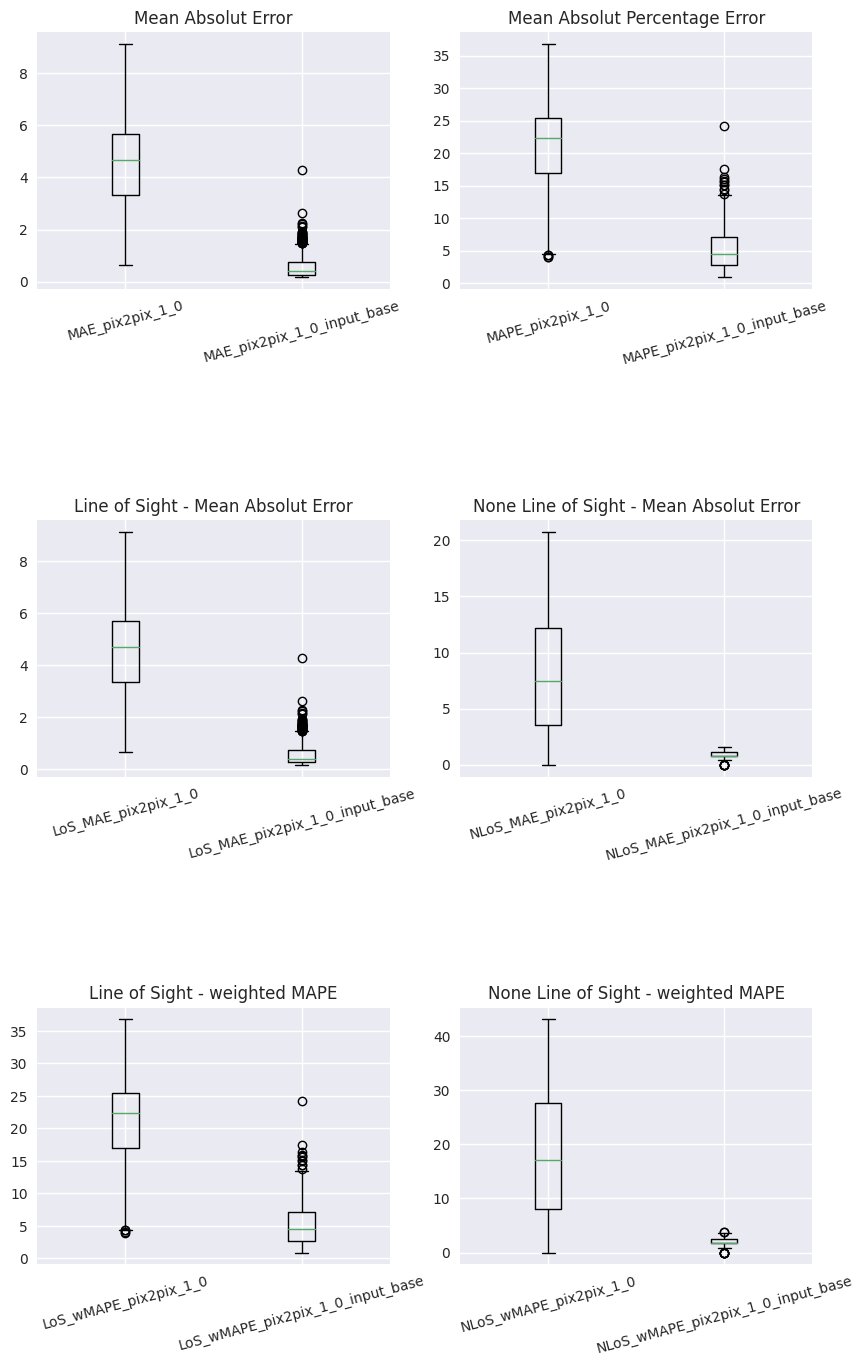

In [47]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 16))
# ax = ax.flatten()

# MEA
values = [merged_df[mae_model_1_name], merged_df[mae_model_2_name]]
names = [mae_model_1_name, mae_model_2_name]
ax[0][0].boxplot(x=values, notch=False)
ax[0][0].set_xticks([1, 2], names)
ax[0][0].set_xticklabels(names, rotation=15)
ax[0][0].set_title("Mean Absolut Error")

# MAPE
values = [merged_df[mape_model_1_name], merged_df[mape_model_2_name]]
names = [mape_model_1_name, mape_model_2_name]
ax[0][1].boxplot(x=values, notch=False)
ax[0][1].set_xticks([1, 2], names)
ax[0][1].set_xticklabels(names, rotation=15)
ax[0][1].set_title("Mean Absolut Percentage Error")

# LoS MEA
values = [merged_df[los_mae_model_1_name], merged_df[los_mae_model_2_name]]
names = [los_mae_model_1_name, los_mae_model_2_name]
ax[1][0].boxplot(x=values, notch=False)
ax[1][0].set_xticks([1, 2], names)
ax[1][0].set_xticklabels(names, rotation=15)
ax[1][0].set_title("Line of Sight - Mean Absolut Error")

# NLoS MEA
values = [merged_df[nlos_mae_model_1_name], merged_df[nlos_mae_model_2_name]]
names = [nlos_mae_model_1_name, nlos_mae_model_2_name]
ax[1][1].boxplot(x=values, notch=False)
ax[1][1].set_xticks([1, 2], names)
ax[1][1].set_xticklabels(names, rotation=15)
ax[1][1].set_title("None Line of Sight - Mean Absolut Error")

# LoS wMAPE
values = [merged_df[los_wmape_model_1_name], merged_df[los_wmape_model_2_name]]
names = [los_wmape_model_1_name, los_wmape_model_2_name]
ax[2][0].boxplot(x=values, notch=False)
ax[2][0].set_xticks([1, 2], names)
ax[2][0].set_xticklabels(names, rotation=15)
ax[2][0].set_title("Line of Sight - weighted MAPE")

# NLoS wMAPE
values = [merged_df[nlos_wmape_model_1_name], merged_df[nlos_wmape_model_2_name]]
names = [nlos_wmape_model_1_name, nlos_wmape_model_2_name]
ax[2][1].boxplot(x=values, notch=False)
ax[2][1].set_xticks([1, 2], names)
ax[2][1].set_xticklabels(names, rotation=15)
ax[2][1].set_title("None Line of Sight - weighted MAPE")

plt.subplots_adjust(hspace=0.9)

print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mae_model_2_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mape_model_2_name].mean():>0.2f}")
print(f"\nLoS MAE\n    - {model_1}: {merged_df[los_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_mae_model_2_name].mean():>0.2f}")
print(f"\nNLoS MAE\n    - {model_1}: {merged_df[nlos_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_mae_model_2_name].mean():>0.2f}")
print(f"\nLoS wMAPE\n    - {model_1}: {merged_df[los_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_wmape_model_2_name].mean():>0.2f}")
print(f"\nNLoS wMAPE\n    - {model_1}: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_wmape_model_2_name].mean():>0.2f}")

Example Image

In [ ]:
def get_same_pred_real_samples(pred_path:str, real_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            if len(cur_id) > 1:
                raise ValueError("Too many ids found!")
            cur_id = cur_id[0]
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                if len(cur_id) > 1:
                    raise ValueError(f"Too many ids found in {cur_image}!")
                elif len(cur_id) <= 0:
                    continue
                    # raise ValueError(f"No id found in {cur_image}!")
                cur_id = cur_id[0]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            if len(cur_id) > 1:
                raise ValueError(f"Too many ids found in {cur_image}!")
            elif len(cur_id) <= 0:
                continue
                # raise ValueError(f"No id found in {cur_image}!")
            cur_id = cur_id[0]
            if cur_id == target_id:
                real_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    result_samples += [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    return result_samples, ids

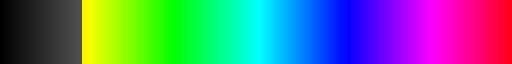

In [49]:
from matplotlib.colors import ListedColormap

def get_unique_hsv_cmap():
    unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
    hsv_map = plt.get_cmap("hsv")
    for cur_idx in range(256):
        r, g, b, a = hsv_map(cur_idx)
        if int(r) > 0.99 and int(g) < (90/255):
            gray_value = cur_idx*2 / 255.0
            unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
        else:
            break
    unique_hsv = ListedColormap(unique_hsv_map)
    plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
    return unique_hsv

# for i in range(256):
#     print([int(cur_color*255) for cur_color in get_cmap('hsv')(i)])

get_unique_hsv_cmap()
plt.get_cmap("unique_hsv")

In [50]:
def plot(ax, path, title="", invert=True, sub_image=None, cmap="unique_hsv", scale=False):
    img = np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

    if sub_image:
        img_2 = np.array(cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE))
        img = cv2.subtract(img, img_2)
    
    # scaling
    if scale:
        mask = (img > 0) & (img < 160)
        img[mask] = np.clip(img[mask] + 40, 0, 255) # cv2.add(img[mask], 30)

    # invert
    if invert:
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    ax.axis("off")
    color_ax = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    
    return color_ax

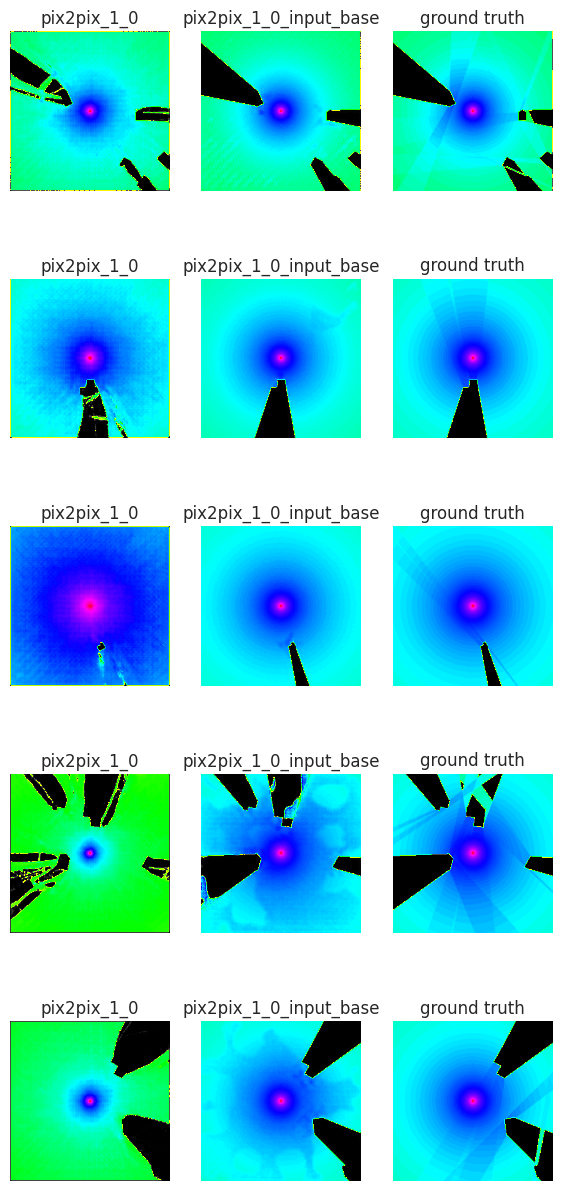

In [59]:
n_samples = 5

example_images_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                    f"../../data/eval/{model_1}/real",
                                                    n_samples)
example_images_model_2, _ = get_same_pred_real_samples(f"../../data/eval/{model_2}/pred",
                                                    f"../../data/eval/{model_2}/real",
                                                    n_samples, ids)

pred_model_1 = example_images_model_1[:n_samples]
pred_model_2 = example_images_model_2[:n_samples]
real = example_images_model_2[n_samples:] 

fig, ax = plt.subplots(nrows=n_samples, ncols=3, figsize=(7, 15))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", invert=True)

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", invert=True)

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", invert=True)

plt.subplots_adjust(hspace=0.5)

plt.show();

In [52]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

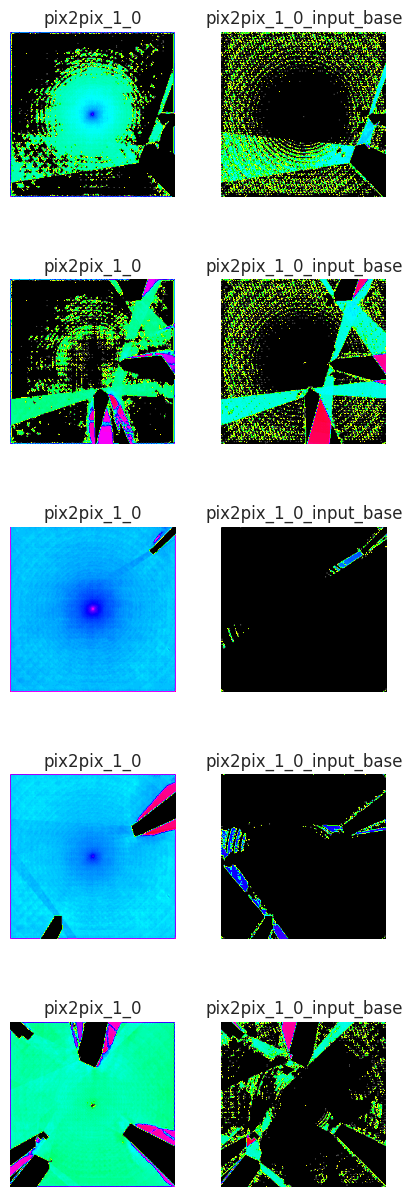

In [52]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(5, 15))

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", sub_image=real[idx], invert=False, scale=True)

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", sub_image=real[idx], invert=False, scale=True)

plt.subplots_adjust(hspace=0.5)
plt.show();

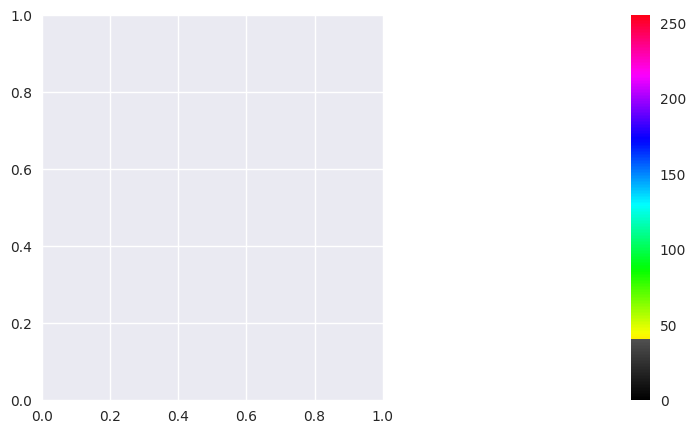

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Create a mappable object (for the colorbar)
norm = plt.Normalize(vmin=0, vmax=255)
sm = plt.cm.ScalarMappable(cmap="unique_hsv", norm=norm)
sm.set_array([])  # Required to set the color range without linking it to any image

fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.4)

plt.show()

### Old Code /Visualization

Examples from pix2pix_1_1


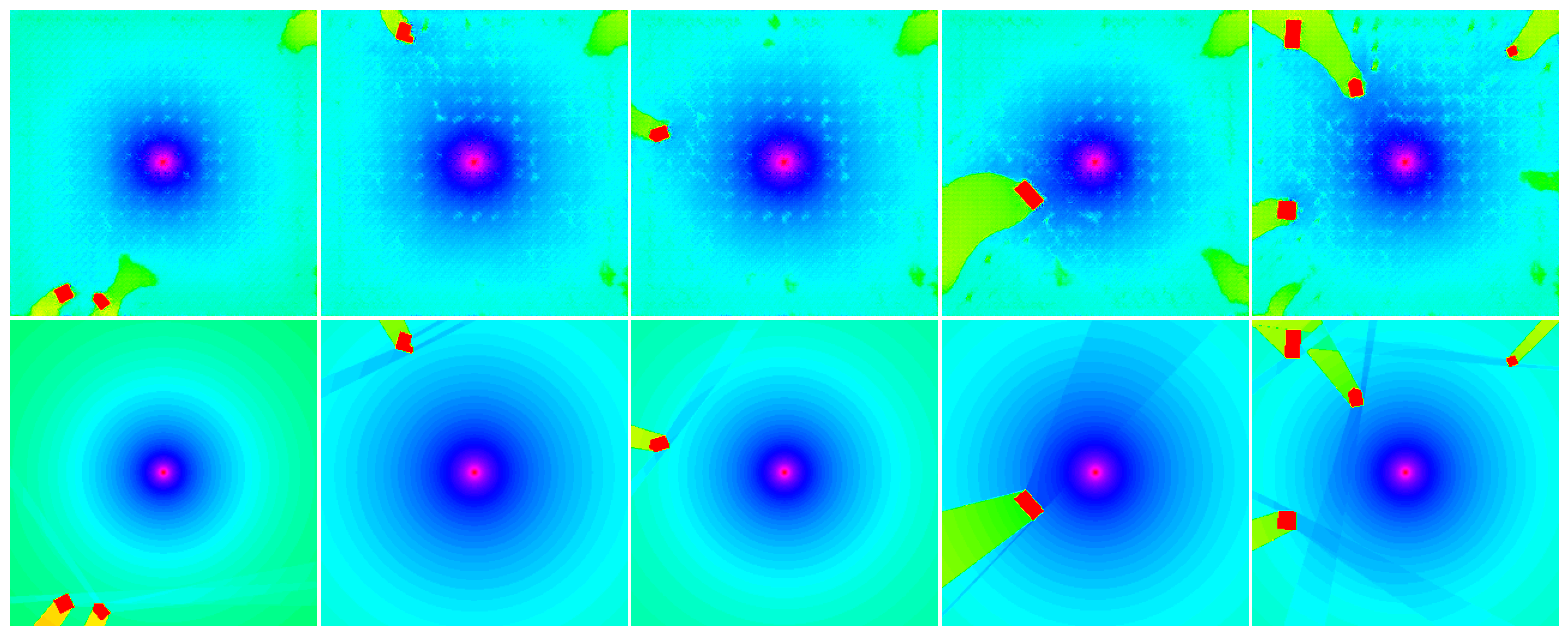

Examples from pix2pix_1_1_input_base


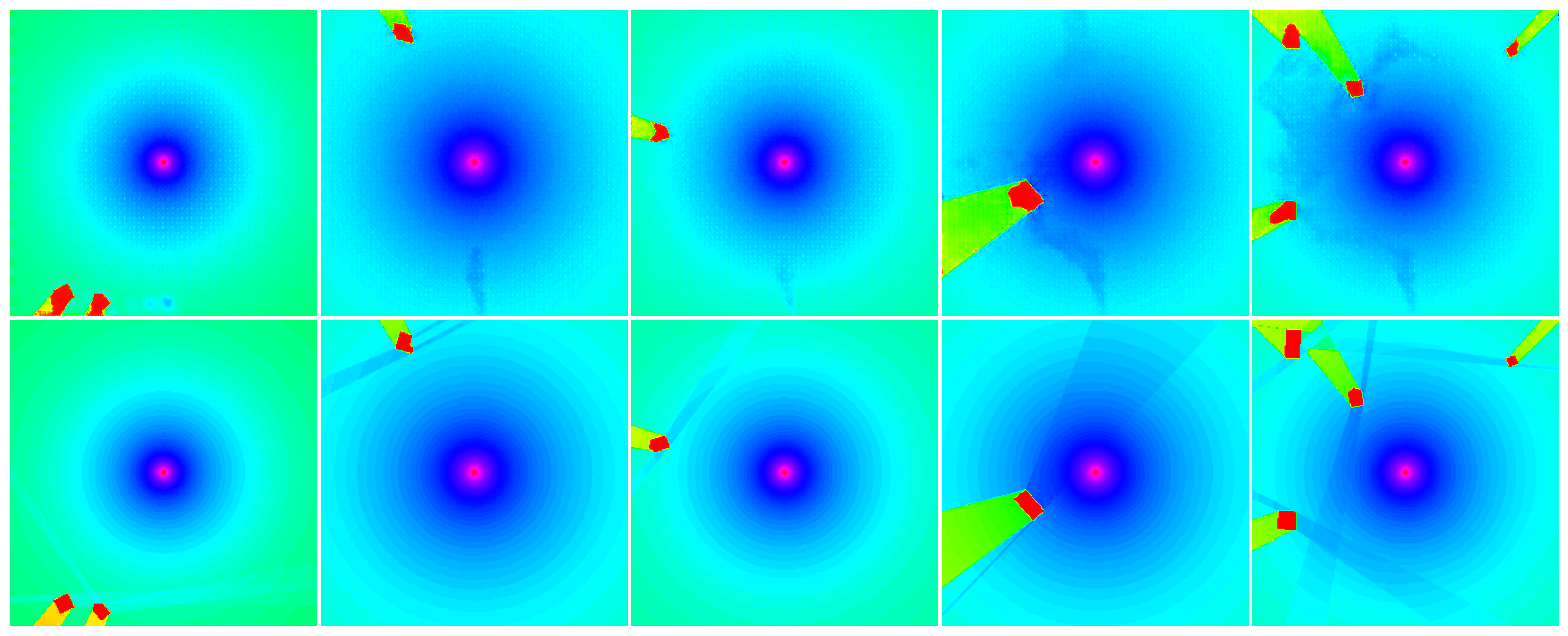

In [55]:
example_images_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                    f"../../data/eval/{model_1}/real",
                                                    5)
print(f"Examples from {model_1}")
show_images(image_paths=example_images_model_1, 
            image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

example_images_model_2, _ = get_same_pred_real_samples(f"../../data/eval/{model_2}/pred",
                                                    f"../../data/eval/{model_2}/real",
                                                    5, ids)
print(f"Examples from {model_2}")
show_images(image_paths=example_images_model_2, 
            image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

Examples from pix2pix_1_1


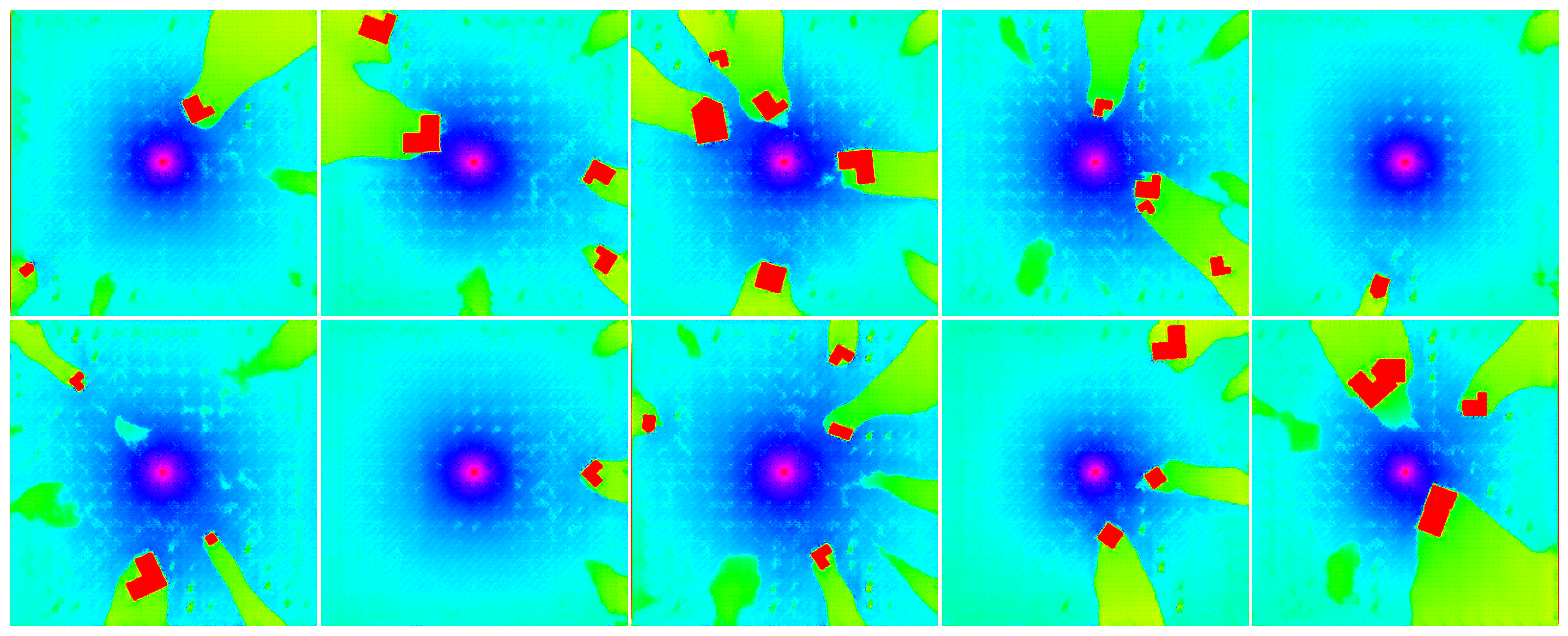

Examples from pix2pix_1_1_input_base


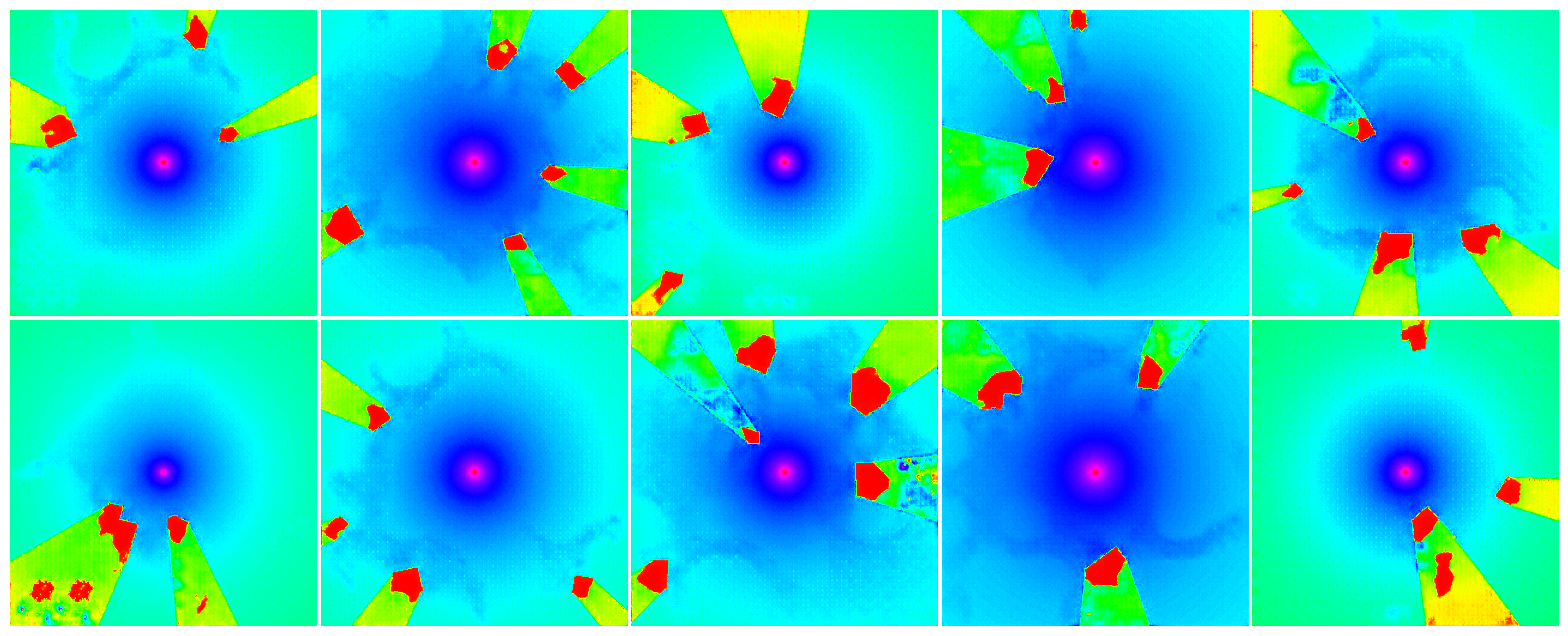

In [56]:
path = f"../../data/eval/{model_1}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_1}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False)

path = f"../../data/eval/{model_2}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_2}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

Amont of unique values: 103


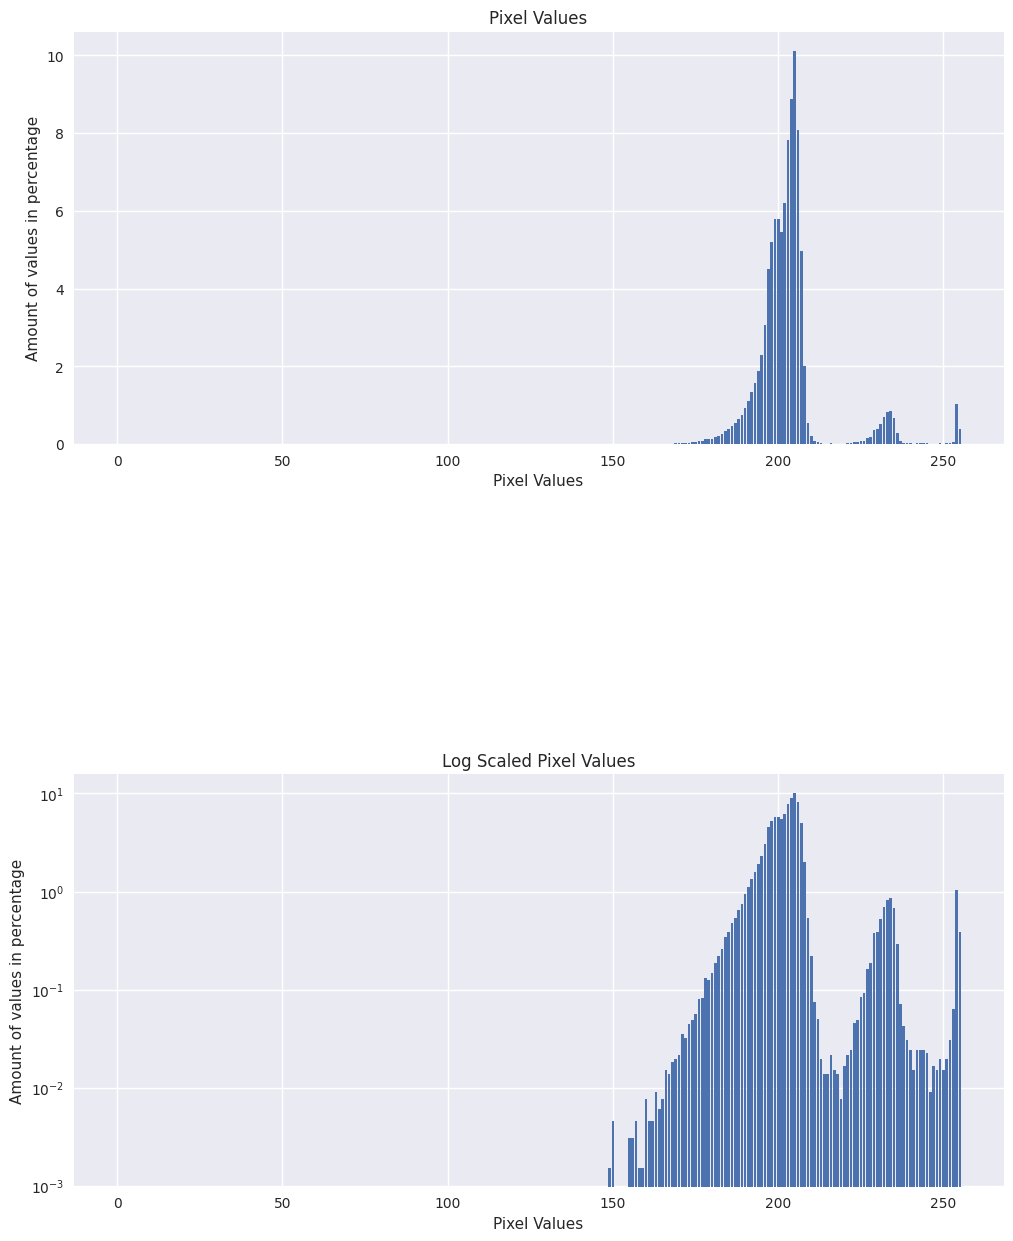

In [57]:
img = cv2.imread(example_images[0], cv2.IMREAD_GRAYSCALE)
unique_values = np.unique(img)
print("Amont of unique values:", len(unique_values))

counts = np.bincount(img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);

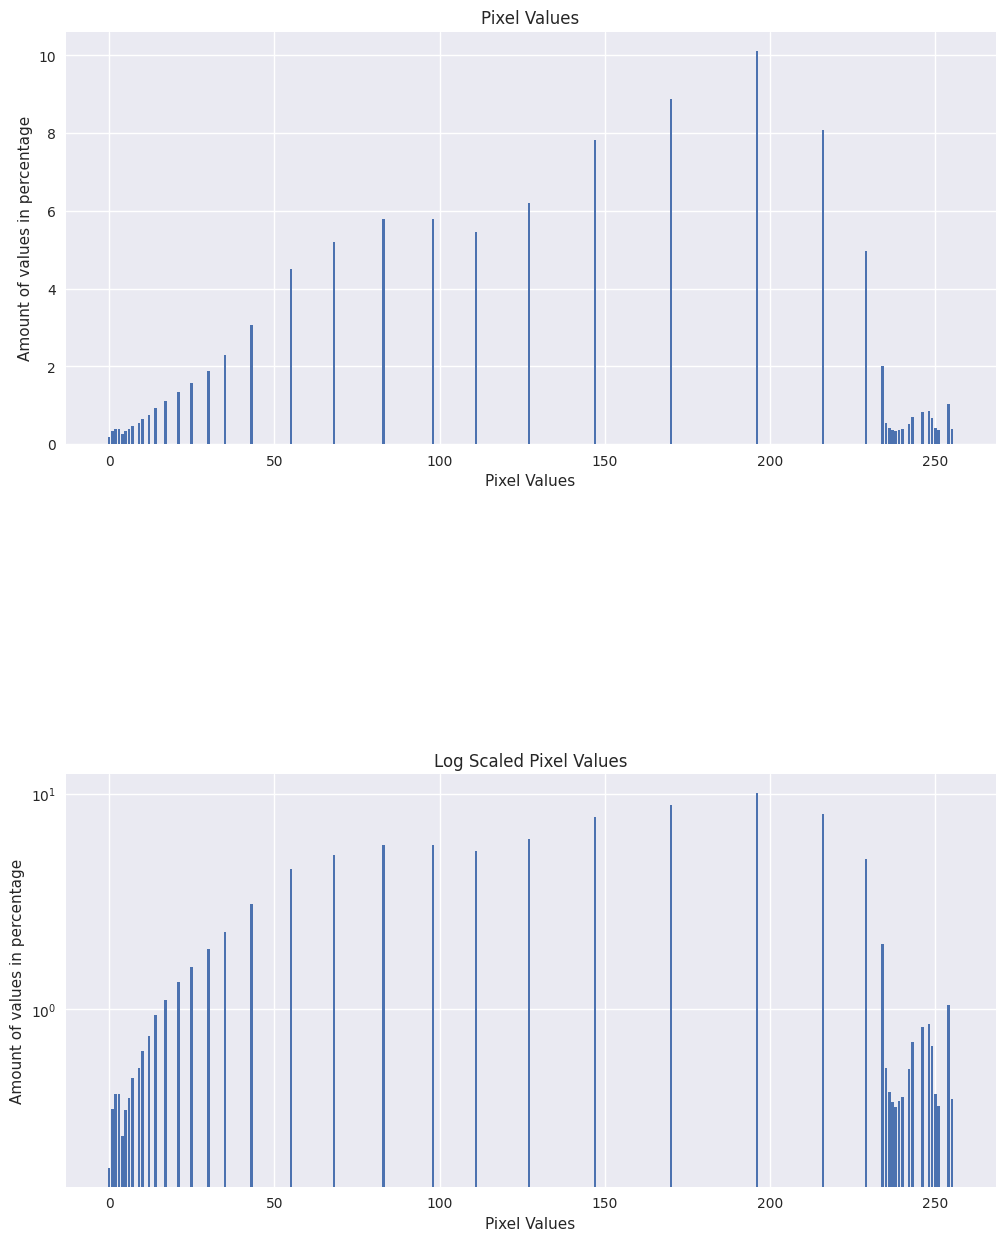

In [58]:
# Apply histogram equalization (clipping values to the range 100-255)
equalized_img = cv2.equalizeHist(img)

counts = np.bincount(equalized_img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);

# # Plot the histogram
# plt.hist(equalized_img.flatten(), bins=256, range=(100, 255), density=True)
# plt.xlabel("Pixel Values")
# plt.ylabel("Frequency")
# plt.show()

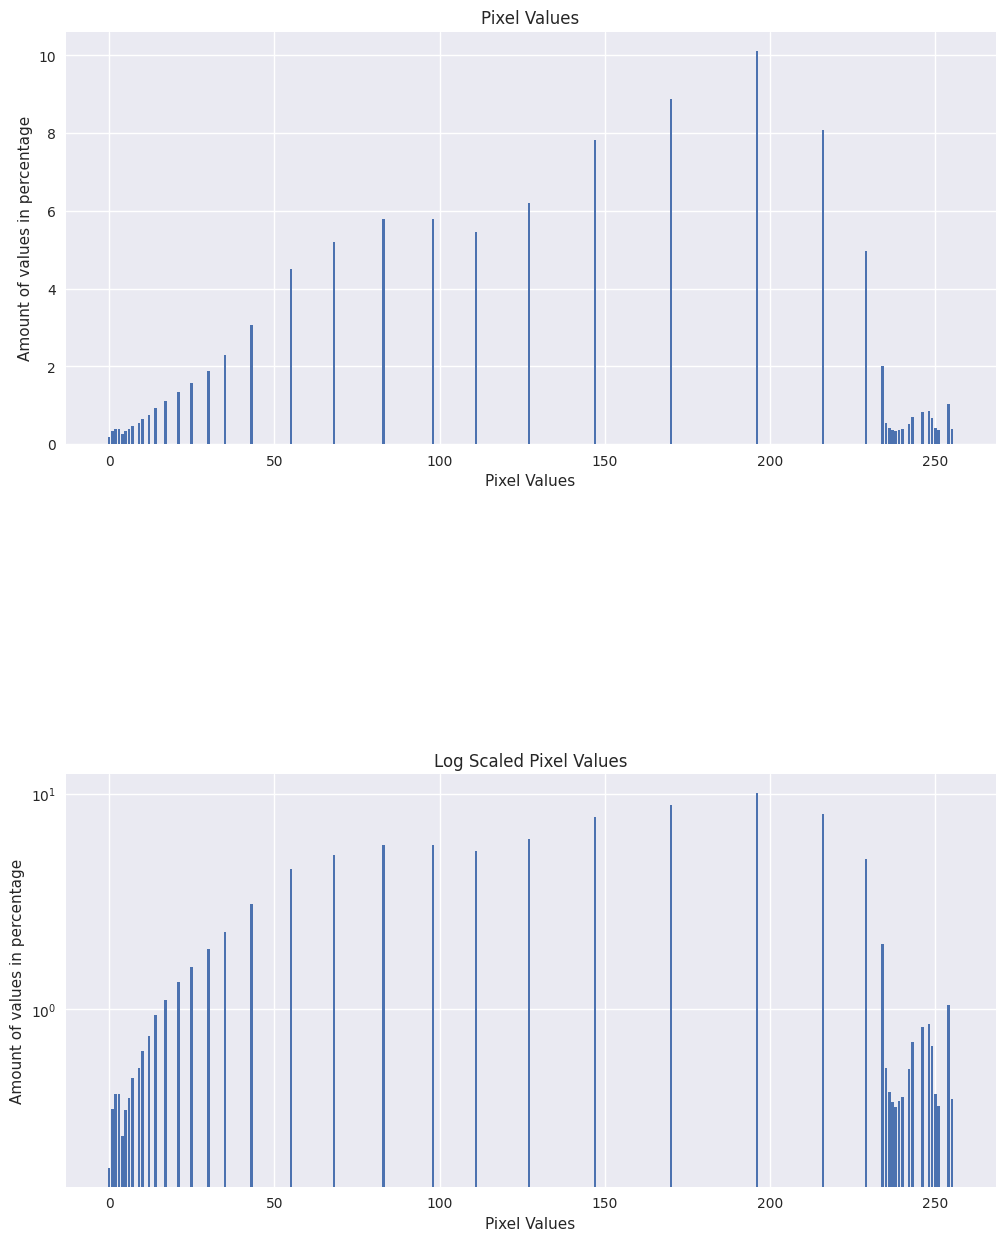

In [59]:
normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
normalized_img = normalized_img * (255)

counts = np.bincount(equalized_img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);